https://ladsweb.modaps.eosdis.nasa.gov/api/v2/content/archives/Document%20Archive/Science%20Data%20Product%20Documentation/VIIRS_Black_Marble_UG_v1.1_July_2020.pdf


In [4]:
import glob
import os
import sys
from osgeo import gdal
import rasterio as rio
from rasterio.merge import merge
import numpy as np
import matplotlib.pyplot as plt
import fiona
import rasterio.mask
import h5py
import rasterio as rio
import datetime as dt
from datetime import date
import subprocess
import matplotlib.dates as mdates
from unittest import result

BASE_PATH = '/Volumes/Sandisk/BlackMarble'
PYONGYANG_FILES_NO_MASK = glob.glob(f'{BASE_PATH}/FINAL_PYONGYANG/No Mask/**.tif')
PYONGYANG_FILES_NO_MASK.sort()
TILES = glob.glob('/Volumes/Sandisk/BlackMarble/RAW/**.h5')
TILES.sort()

dates = {}

# /Volumes/Sandisk/BlackMarble/RAW/

for file in TILES:
    name = str(file).split('/')[5].split('.')[1]
    if name not in dates.keys():
        dates[name] = 0
    dates[name] += 1

for key in dates.keys():
    if dates[key] != 4:
        print(f'ERROR: the following dates do not have 4 granules: {key}')

In [ ]:
## List input raster files

def buildInitialTifs():

    for file in TILES:   

        hdflayer = gdal.Open(file, gdal.GA_ReadOnly) # Initiate opening of HDF5 file

        subhdflayer = hdflayer.GetSubDatasets()[2][0] # Read the Gap_Filled_DNB_BRDF-Corrected_NTL field
        rlayer = gdal.Open(subhdflayer, gdal.GA_ReadOnly) # Load NTL data into rlayer

        qualitylayer = hdflayer.GetSubDatasets()[4][0] # Read the Mandatory_Quality_Flag field
        qlayer = gdal.Open(qualitylayer, gdal.GA_ReadOnly) # Load quality layer data into qlayer

        # /Volumes/Sandisk/BlackMarble/RAW/
        outputName = str(file).split('/')[5]
        qualityOutputName = str(file).split('/')[5] + ' Quality'

        HorizontalTileNumber = int(rlayer.GetMetadata_Dict()["HorizontalTileNumber"])
        VerticalTileNumber = int(rlayer.GetMetadata_Dict()["VerticalTileNumber"])
        WestBoundCoord = (10*HorizontalTileNumber) - 180
        NorthBoundCoord = 90-(10*VerticalTileNumber)
        EastBoundCoord = WestBoundCoord + 10
        SouthBoundCoord = NorthBoundCoord - 10

        EPSG = "-a_srs EPSG:4326" #WGS84

        translateOptionText = EPSG +" -a_ullr " + str(WestBoundCoord) + " " + str(NorthBoundCoord) + " " + str(EastBoundCoord) + " " + str(SouthBoundCoord)

        translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine(translateOptionText))
        gdal.Translate(f'{BASE_PATH}/Tiles as Tifs/' + outputName + '.tif', rlayer, options = translateoptions)
        gdal.Translate(f'{BASE_PATH}/Quality as Tifs/' + qualityOutputName + '.tif', qlayer, options = translateoptions)
    
    raster_files = glob.glob(f'{BASE_PATH}/Tiles as Tifs/**.tif')
    raster_files.extend(glob.glob(f'{BASE_PATH}/Quality as Tifs/**.tif'))
    raster_files.sort()
    
    master_array = []
    
    i = 0
    while i != len(raster_files):
        master_array.append([raster_files[i], raster_files[i+1], raster_files[i+2], raster_files[i+3]])
        i += 4

    for quad in master_array:
    
        raster_to_mosaic = []

        for item in quad:
            individual_frame = rio.open(item)
            raster_to_mosaic.append(individual_frame)
            output_meta = individual_frame.meta.copy()

        output_name = quad[0].split('/')[5].split('.')[1]    
        mosaic, output = merge(raster_to_mosaic)
        output_meta.update({"driver": "GTiff", "height": mosaic.shape[1], "width": mosaic.shape[2],"transform": output})

        qual_extension = ' Quality'
        
        if 'Quality' in quad[0]:
            output_path = f'{BASE_PATH}/Merged Tiles/' + output_name + qual_extension + '.tif'
        else:
            output_path = f'{BASE_PATH}/Merged Tiles/' + output_name + '.tif'
        
        with rio.open(output_path, 'w', **output_meta) as m:
            m.write(mosaic)

        # Delete the raw .tif tiles that were extracted from h5 data.
        for item in quad:
            os.remove(item) 
    
    large_mosaics = glob.glob(f'{BASE_PATH}/Merged Tiles/**.tif')
    large_mosaics.sort()
    
    # /Volumes/Sandisk/BlackMarble/Merged Tiles
    for file in large_mosaics:
    
        output_name = file.split('/')[5]

        with fiona.open('/Users/ethanjewell/Desktop/Python Env/Scripting/Map Data/Shapefiles/Korean Peninsula/Korean Peninsula.shp') as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]

        with rio.open(file) as src:
            out_image, out_transform = rio.mask.mask(src, shapes, nodata=65535, crop=True)
            out_meta = src.meta
            out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

        if 'Quality' in output_name:
            with rio.open(f'{BASE_PATH}/DPRK Only/quality_masks/' + str(output_name), "w", **out_meta) as dest:
                dest.write(out_image)

        else:
            with rio.open(f'{BASE_PATH}/DPRK Only/ntl_data/' + str(output_name), "w", **out_meta) as dest:
                dest.write(out_image)
        
        # Delete the merged file once it has been used to generate the NTL and Quality files covering the Korean Peninsula
        os.remove(file)
                
    print('Initial tifs created.')

In [ ]:
def createUnmaskedTifsAndPngs():

    # /Volumes/Sandisk/BlackMarble/DPRK Only/quality_masks/
    ntls = glob.glob(f'{BASE_PATH}/DPRK Only/ntl_data/**.tif')

    i = 0

    while i < len(ntls):
        ntl = gdal.Open(ntls[i])
        
        output_name = str(ntls[i]).split('/')[6]
        
        ntl_meta = ntl.GetMetadata()                   # Store metadata in dictionary
        ntl_rows, ntl_cols = ntl.RasterYSize, ntl.RasterXSize  # Number of rows,columns
        ntl_geotransform = ntl.GetGeoTransform()
        ntl_proj = ntl.GetProjection() 

        NTLBand = ntl.GetRasterBand(1)
        NTLData = NTLBand.ReadAsArray().astype('float') # Data for export as unamsked tif
        NTLData *= 0.1 # Apply scale per BlackMarble documentation

        unmasked_outpath = f'{BASE_PATH}/FINAL_NATIONAL/No Mask/'

        os.chdir(unmasked_outpath)
        driver = gdal.GetDriverByName('GTiff')                                          # Select GDAL GeoTIFF driver
        outfile = driver.Create(output_name, ntl_cols, ntl_rows, 1, gdal.GDT_Float32)          # Specify the parameters of the GeoTIFF
        outfile.SetGeoTransform(ntl_geotransform)                                           # Set Geotransform
        band = outfile.GetRasterBand(1)                                                 # Get band 1
        band.WriteArray(NTLData)                                                            # Write the array to band 1
        outfile.SetProjection(ntl_proj)                                                     # Set projection
        band.FlushCache()                                                               # Export data
        band.SetNoDataValue(65535)                                                    # Set fill value
        outfile = None                                                                  # Close ntls[i]

        plt.figure(figsize = (10,7.5))    # Set the figure size (x,y)
        plt.axis('off')
        plt.imshow(NTLData, vmin = 0, vmax = 10, cmap = 'Greys_r');
        plt.savefig(f'{BASE_PATH}/Images/No Mask/' + output_name + '.png', transparent = True)
        plt.close()

        ntl = None
        mask = None
        i += 1

    print('Unmasked tifs and pngs created.')

In [38]:
def createMaskedTifsAndPngs():

    masks = glob.glob(
        f'{BASE_PATH}/DPRK Only/quality_masks/**.tif')
    ntls = glob.glob(
        f'{BASE_PATH}/DPRK Only/ntl_data/**.tif')
    masks.sort()  # CRUCIAL to ensure masks and ntl data sets line up for processing
    ntls.sort()  # CRUCIAL to ensure masks and ntl data sets line up for processing

    i = 1500

    while i < len(masks):

        mask = gdal.Open(masks[i])
        ntl = gdal.Open(ntls[i])

        output_name = str(ntls[i]).split('/')[6]

        ntl_meta = ntl.GetMetadata()                   # Store metadata in dictionary
        ntl_rows, ntl_cols = ntl.RasterYSize, ntl.RasterXSize  # Number of rows,columns
        ntl_geotransform = ntl.GetGeoTransform()
        ntl_proj = ntl.GetProjection()

        mask_meta = mask.GetMetadata()                   # Store metadata in dictionary
        mask_rows, mask_cols = mask.RasterYSize, mask.RasterXSize  # Number of rows,columns
        mask_geotransform = mask.GetGeoTransform()
        mask_proj = mask.GetProjection()

        NTLBand = ntl.GetRasterBand(1)
        NTLData = NTLBand.ReadAsArray().astype(
            'float')  # Data for export as unamsked tif
        NTLData *= 0.1  # Apply scale per BlackMarble documentation

        MASKBand = mask.GetRasterBand(1)
        MaskData = MASKBand.ReadAsArray().astype('float')
        # Mask array, only include high-quality bits, for export to tif
        MASKED_NTL = np.ma.MaskedArray(
            NTLData, np.in1d(MaskData, [0, 1], invert=False))

        masked_outpath = f'{BASE_PATH}/FINAL_NATIONAL/With Mask/'

        os.chdir(masked_outpath)
        # Split mask from data
        MASKED_NTL.unshare_mask()
        # Set masked values equal to fill value
        MASKED_NTL[MASKED_NTL.mask == True] = 65535
        # Select GDAL GeoTIFF driver
        driver = gdal.GetDriverByName('GTiff')
        # Specify the parameters of the GeoTIFF
        outfile = driver.Create(output_name, ntl_cols,
                                ntl_rows, 1, gdal.GDT_Float32)
        # Set Geotransform
        outfile.SetGeoTransform(ntl_geotransform)
        # Get band 1
        band = outfile.GetRasterBand(1)
        # Write the array to band 1
        band.WriteArray(MASKED_NTL)
        # Set projection
        outfile.SetProjection(ntl_proj)
        # Export data
        band.FlushCache()
        # Set fill value
        band.SetNoDataValue(65535)
        # Close file
        outfile = None

        plt.figure(figsize=(10, 7.5))    # Set the figure size (x,y)
        plt.axis('off')
        plt.imshow(MASKED_NTL, vmin=0, vmax=10, cmap='Greys_r')
        plt.savefig(f'{BASE_PATH}/Images/With Mask/' +
                    output_name + '.png', transparent=True)
        plt.close()

        ntl = None
        mask = None
        i += 1

    print('Masked tifs and pngs created.')

In [39]:
createMaskedTifsAndPngs()

: 

: 

In [5]:
sliceProvince('NK', 'Pyongyang', True)

Pyongyang tifs created.


In [2]:
# CN must be an upper-case 'NK' or 'SK' string
# city must be an all lower-case name of a city in the respective Korea

def sliceProvince(CN, city, mask):

    city_upper = city.upper()
    city_shp = city_upper[0] + city_upper[1:].lower()
    
    # /Volumes/Sandisk/BlackMarble/FINAL_NATIONAL/With Mask/
    if mask == True:
        dprk_tifs = glob.glob(f'{BASE_PATH}/FINAL_NATIONAL/With Mask/**.tif')
    else:
        dprk_tifs = glob.glob(f'{BASE_PATH}/FINAL_NATIONAL/No Mask/**.tif')  
    
    for file in dprk_tifs:

        output_name = file.split('/')[6]
        
        with fiona.open(f'/Users/ethanjewell/Desktop/Python Env/Scripting/Map Data/Shapefiles/{CN} 6 Cities/{city_shp}.shp') as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]

        with rio.open(file) as src:
            out_image, out_transform = rio.mask.mask(src, shapes, crop=True)
            out_meta = src.meta
            out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

        if mask == True:
            with rio.open(f'{BASE_PATH}/FINAL_{city_upper}/With Mask/' + str(output_name), "w", **out_meta) as dest:
                dest.write(out_image)    
        else:
            with rio.open(f'{BASE_PATH}/FINAL_{city_upper}/No Mask/' + str(output_name), "w", **out_meta) as dest:
                dest.write(out_image)

    print(f'{city_shp} tifs created.')

In [ ]:
def showTif(specific_file):
    file = gdal.Open(specific_file)
    band = file.GetRasterBand(1)
    data = band.ReadAsArray().astype('float') # Import band as an array with type float
    print(np.nanmax(data))
    
    plt.figure(figsize = (10,7.5))    # Set the figure size (x,y)
    plt.axis('off')                   # Remove the axes' values
    # Plot the array, using a colormap and setting a custom linear stretch based on the min/max EVI values
    plt.imshow(data, vmin = 0, vmax = 10, cmap = 'Greys_r');
    file = None

In [14]:
# USAGE: plotRadiance(glob.glob('path to file full of rasters', 'province', createDateRange('MM/DD/YYYY', 'MM/DD/YYYY')))
# The third argument is optional. If left blank, plotRadiance will plot all the files in the folder passed to it in the first argument. This means default range is about 10 years.

def plotRadiance(raster_names, province, date_range=[]):
    rasters = []

    if len(date_range) > 0:
        for name in raster_names:
            if any(ele in name for ele in date_range):
                rasters.append(name)
    else:
        rasters = raster_names    

    rasters.sort()
    valid_rasters = []
    result_points = []
    x_labels = []
    
    for raster in rasters:
        
        raster_data = np.array(createRasterData(raster)).flatten()
        raster_data[raster_data == 65535] = np.nan
        valid_pixels = np.count_nonzero(~np.isnan(raster_data))

        # Find what percentage of the masked image is valid (i.e., not negated by a bad quality flag)
        percent = valid_pixels/calcValidPixels(province)
        
        # Only add rasters to list for analysis if they are 99% or more valid data
        if (percent >= 0.80) and (np.nanmean(raster_data) < 1000):
            mean = np.nanmean(raster_data)
            result_points.append(mean)
            valid_rasters.append(raster)
       
    for entry in valid_rasters:
        # /Volumes/Sandisk/BlackMarble/FINAL_PYONGYANG/With Mask/A2022131.tif
        name = entry.split('/')[6]
        julian_date = name[1:8]
        date = dt.datetime.strptime(julian_date, '%Y%j').strftime('%m/%d/%Y')              # Convert YYYYDDD to MM/DD/YYYY
        # Add the rasters date as a string for later use in graph
        x_labels.append(date)

    # Create list of datetime objects for the x-axis        
    x_datetimes = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in x_labels]
    
    fig, ax = plt.subplots(figsize = (20,7))
    
    ax.set_title(f'Radiance of {province} at night')
    ax.set_ylabel('Radiance = ' + r'$\left (\frac{nW}{(cm^2)sr}\right)$')
    ax.set_xlabel('Date')
    # ax.set_ylim([0, max(result_points) + 10]) # Sets the y-axis min and max
    
    # First arg is the datetime objects, second is how the graph should display them
    ax.set_xticks(x_datetimes, x_labels)
    
    plt.style.use('dark_background')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(plt.LinearLocator()) # Forces even spacing of x-axis ticks
    plt.scatter(x_datetimes, result_points)

    print(province.upper())
    min_loc = result_points.index(min(result_points))
    print(f'The least bright day was {x_labels[min_loc]}')
    max_loc = result_points.index(max(result_points))
    print(f'The brightest day was {x_labels[max_loc]}' + '\n')

    plt.savefig(f'{BASE_PATH}/Charts/{province}')

In [15]:
def createRasterData(raster):
    ntl = gdal.Open(raster)
    NTLBand = ntl.GetRasterBand(1)
    NTLData = NTLBand.ReadAsArray()
    return NTLData

def createDateRange(start, end):
    startdate = dt.datetime.strptime(start, '%m/%d/%Y').date().strftime('%Y%j')
    enddate = dt.datetime.strptime(end, '%m/%d/%Y').date().strftime('%Y%j')
    dateranges = list(np.arange(int(startdate), int(enddate)))
    tif_names = []

    for d in dateranges:
        d = 'A' + str(d) + '.tif'
        tif_names.append(d)

    return tif_names

def calcValidPixels(province):
    raster_data = np.array(createRasterData(f'/Volumes/Sandisk/BlackMarble/FINAL_{province.upper()}/No Mask/A2020275.tif')).flatten()
    raster_data[raster_data == 65535] = np.nan
    total_pixels = np.count_nonzero(~np.isnan(raster_data))
    return total_pixels

def generate_date_list(): # Used to update global variable DATES when new files are added to the RAW working directory

    result_array = []
    
    for file in TILES:
        title = file.split('/')[5].split('.')[1]
        yyyyddd = title[1:8]                                          # First: product name
        date = dt.datetime.strptime(yyyyddd, '%Y%j').strftime('%m/%d/%Y')              # Convert YYYYDDD to MM/DD/YYYY
        result_array.append(date)
        
    return result_array

PYONGYANG
The least bright day was 02/17/2022
The brightest day was 07/12/2012



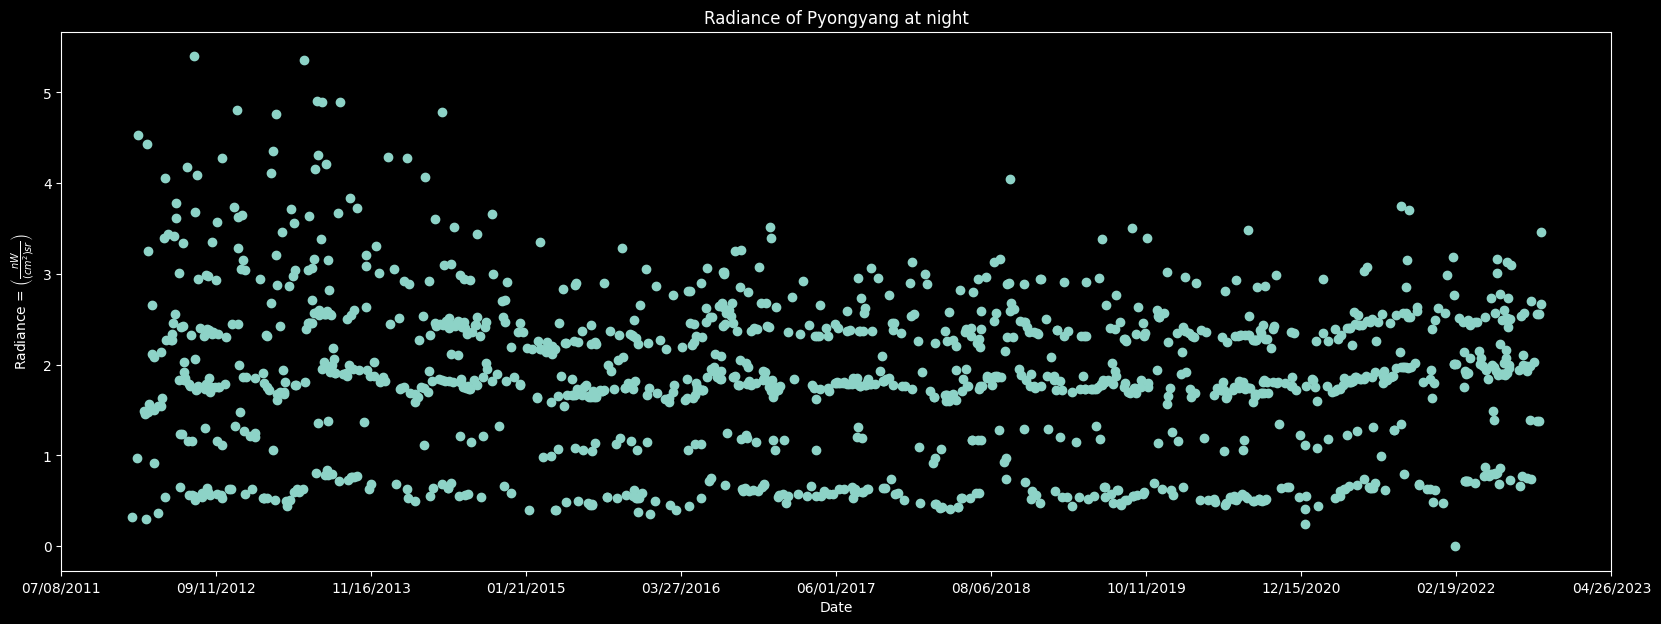

In [16]:
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_SEOUL/With Mask/**.tif'), 'Seoul')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_GWANGJU/With Mask/**.tif'), 'Gwangju')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_BUSAN/With Mask/**.tif'), 'Busan')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_DAEJEON/With Mask/**.tif'), 'Daejeon')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_INCHEON/With Mask/**.tif'), 'Incheon')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_DAEGU/With Mask/**.tif'), 'Daegu')

plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_PYONGYANG/With Mask/**.tif'), 'Pyongyang')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_SINUIJU/With Mask/**.tif'), 'Sinuiju')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_CHONGJIN/With Mask/**.tif'), 'Chongjin')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_HAMHUNG/With Mask/**.tif'), 'Hamhung')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_NAMPHO/With Mask/**.tif'), 'Nampho')
# plotRadiance(glob.glob(f'{BASE_PATH}/FINAL_WONSAN/With Mask/**.tif'), 'Wonsan')